# Imports & Env. Config

In [35]:
!pip install mmcif_pdbx
!pip install pandas-profiling
!pip install pyarrow
!pip install biopython
!chmod 777 -R /home/jupyter/pss/blast

# mmCIF / Protein Libs
import pdbx
from pdbx.reader import PdbxReader
from pdbx.reader import DataContainer
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# I/O Libs
from google.cloud import storage
import io
from io import StringIO
import os
from IPython.display import clear_output

# Data Manipulation Libs
import pandas as pd
import numpy as np
import math
import random
import gzip
import pyarrow as pa
import pyarrow.parquet as pq

# Viz Libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()

# ML Libs
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.datasets import make_blobs

os.environ['PATH'] = '/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/pss/blast/bin/:'

clear_output()

In [3]:
# Instantiates a client & loads credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
storage_client = storage.Client()

# Download List of Filenames (mmCIF) From GCS

In [4]:
filenames = []
blob_list = storage_client.get_bucket('capstone-fall21-protein').list_blobs()
for blob in blob_list:
    if 'UP000005640_9606_HUMAN/cif/' in blob.name:
        filenames.append(blob.name)
print(f'Indexed {len(filenames)} files.')

Indexed 23391 files.


# Baseline: BLAST Scores + e-Values for Randomly Clustered Proteins

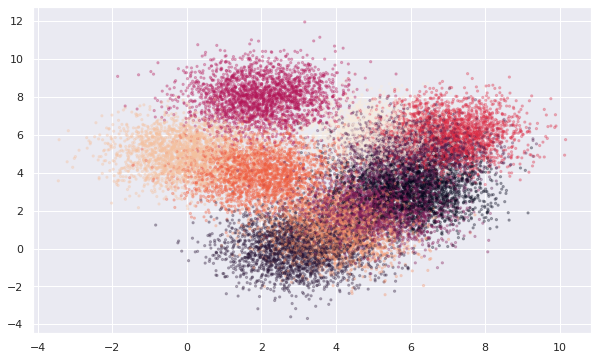

In [5]:
# create random clusters of len(filenames)

centers = [(random.randrange(0, 10), random.randrange(0, 10)) for i in range(10)]
X, y = make_blobs(n_samples=len(filenames), centers=centers, n_features=500, random_state=42)
figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=5, alpha=0.3);

In [6]:
# extract cluster 1 intercepts + assign to first len(cluster_1) proteins in filenames

cluster_1 = X[y == 1]
cluster_1_examples = pd.DataFrame(cluster_1)
cluster_1_examples['protein'] = pd.DataFrame(filenames[:len(cluster_1_examples)])
cluster_1_examples.head()

,0,1,protein
0,2.225037,1.368094,UP000005640_9606_HUMAN/cif/AF-A0A024R1R8-F1-mo...
1,2.421540,-0.077494,UP000005640_9606_HUMAN/cif/AF-A0A024RBG1-F1-mo...
2,2.023380,0.160269,UP000005640_9606_HUMAN/cif/AF-A0A024RCN7-F1-mo...
3,2.483386,-1.023253,UP000005640_9606_HUMAN/cif/AF-A0A075B6H5-F1-mo...
4,2.806390,0.744586,UP000005640_9606_HUMAN/cif/AF-A0A075B6H7-F1-mo...


In [9]:
def get_atoms(selection=None):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    data=[]
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    
    if selection is None:
        selection = filenames

    for file in selection:
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
        blob.download_to_filename(alias)

        with gzip.open(alias) as f:
            file_content = f.read()

        txt = io.StringIO(file_content.decode("utf-8"))

        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        txt.close()
        block = data[0]

        obj = block.get_object("atom_site")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])

    os.remove(alias)
    print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.append(result[:,10:13], result[:,21].reshape(len(result),1), axis=1)
    return result

In [12]:
cluster_1_atoms = get_atoms(cluster_1_examples['protein'].to_list()[6:10])
pd.DataFrame(cluster_1_atoms, columns=['X', 'Y', 'Z', 'protein'])

Processed 4 proteins (3588 rows).


,X,Y,Z,protein
0,18.520,33.259,-49.110,A0A075B6H9
1,18.352,32.055,-48.267,A0A075B6H9
2,17.552,32.454,-47.034,A0A075B6H9
3,19.719,31.461,-47.879,A0A075B6H9
4,18.119,32.976,-46.089,A0A075B6H9
...,...,...,...,...
3583,14.752,19.558,-2.888,A0A075B6H9
3584,11.575,21.621,-2.619,A0A075B6H9
3585,12.611,23.166,-4.385,A0A075B6H9
3586,11.238,22.678,-1.570,A0A075B6H9


In [ ]:
# TODO: Add amino acid sequence to return array of get_atoms() so we can run BLAST

# BLAST Example

In [34]:
# First download and unpack BLAST+ (linux x86) at /home/jupyter/pss/blast/
# Make sure /home/jupyter/pss/blast/bin/* has been chmod 777'd

# Create two sequence files
seq1 = SeqRecord(Seq("MPKLNSTFVTEFLFEGFSSFRRQHKLVFFVVFLTLYLLTLSGNVIIMTIIRLDHHLHTPMYFFLCMLSISETCYTVAIIPHMLSGLLNPHQPIATQSCATQLFFYLTFGINNCFLLTVMGYDRYVAICNPLRYSVIMGKRACIQLASGSLGIGLGMAIVQVTSVFGLPFCDAFVISHFFCDVRHLLKLACTDTTVNEIINFVVSVCVLVLPMGLVFISYVLIISTILKIASAEGQKKAFATCASHLTVVIIHYGCASIIYLKPKSQSSLGQDRLISVTYTHHSPTEPCCVQPEEQGGQRCSAQSRGAKNSVSLMKRGCEGFSFAFINMY"), id="Q5JRS4")
seq2 = SeqRecord(Seq("YFLQTLCSVLGEYYTPALKCEVNAEDKENSGDYISENEDPELQDYRYEVQDFQENMHTLLNKVTEEYNKLLVLQTRLSKIWGQQTDGMKLEFGEENLPKEETEFLSIHSQMTNLEDIDVNHKSKLSSLQDLEKTKLEEQVQELESLISSLQQQLKETEQNYEAEIHCLQKRLQAVSESTVPPSLPVDSVVITESDAQRTMYPGSCVKKNIDGTIEFSGEFGVKEETNIVKLLEKQYQEQLEEEVAKVIVSMSIAFAQQTELSRISGGKENTASSKQAHAVCQQEQHYFNEMKLSQDQIGFQTFETVDVKFKEEFKPLSKELGEHGKEILLSNSDPHDIPESKDCVLTISEEMFSKDKTFIVRQSIHDEISVSSMDASRQLMLNEEQLEDMRQELVRQYQEHQQATELLRQAHMRQMERQREDQEQLQEEIKRLNRQLAQRSSIDNENLVSERERVLLEELEALKQLSLAGREKLCCELRNSSTQTQNGNENQGEVEEQTFKEKELDRKPEDVPPEILSNERYALQKANNRLLKILLEVVKTTAAVEETIGRHVLGILDRSSKSQSSASLIWRSEAEASVKSCVHEEHTRVTDESIPSYSGSDMPRNDINMWSKVTEEGTELSQRLVRSGFAGTEIDPENEELMLNISSRLQAAVEKLLEAISETSSQLEHAKVTQTELMRESFRQKQEATESLKCQEELRERLHEESRAREQLAVELSKAEGVIDGYADEKTLFERQIQEKTDIIDRLEQELLCASNRLQELEAEQQQIQEERELLSRQKEAMKAEAGPVEQQLLQETEKLMKEKLEVQCQAEKVRDDLQKQVKALEIDVEEQVSRFIELEQEKNTELMDLRQQNQALEKQLEKMRKFLDEQAIDREHERDVFQQEIQKLEQQLKVVPRFQPISEHQTREVEQLANHLKEKTDKCSELLLSKEQLQRDIQERNEEIEKLEFRVRELEQALLVSADTFQKVEDRKHFGAVEAKPELSLEVQLQAERDAIDRKEKEITNLEEQLEQFREELENKNEEVQQLHMQLEIQKKESTTRLQELEQENKLFKDDMEKLGLAIKESDAMSTQDQHVLFGKFAQIIQEKEVEIDQLNEQVTKLQQQLKITTDNKVIEEKNELIRDLETQIECLMSDQECVKRNREEEIEQLNEVIEKLQQELANIGQKTSMNAHSLSEEADSLKHQLDVVIAEKLALEQQVETANEEMTFMKNVLKETNFKMNQLTQELFSLKRERESVEKIQSIPENSVNVAIDHLSKDKPELEVVLTEDALKSLENQTYFKSFEENGKGSIINLETRLLQLESTVSAKDLELTQCYKQIKDMQEQGQFETEMLQKKIVNLQKIVEEKVAAALVSQIQLEAVQEYAKFCQDNQTISSEPERTNIQNLNQLREDELGSD"), id="Q99996")
SeqIO.write(seq1, "seq1.fasta", "fasta")
SeqIO.write(seq2, "seq2.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastpCommandline(query="seq1.fasta", subject="seq2.fasta", outfmt=5)()[0]
blast_result_record = NCBIXML.read(StringIO(output))

# The BLAST E-value is the number of expected hits of similar quality (score)
# that could be found just by chance. E-value of 10 means that up to 10 hits can
# be expected to be found just by chance, given the same size of a random
# database. The lower the E-value, or the closer it is to zero, the more 
# "significant" the match is.

# The bit score, S', is derived from the raw alignment score, S, taking the
# statistical properties of the scoring system into account. Because bit scores 
# are normalized with respect to the scoring system, they can be used to compare
# alignment scores from different searches. Higher is better, but after 50 there
# is little added statistical benefit.

for alignment in blast_result_record.alignments:
    for hsp in alignment.hsps:
        print('****Alignment****')
        print('sequence:', alignment.title)
        print('length:', alignment.length)
        print('e value:', hsp.expect)
        print('score:', hsp.score)
        #print(hsp.query)
        #print(hsp.match)
        #print(hsp.sbjct)

****Alignment****
sequence: Q99996 Q99996 <unknown description>
length: 1400
e value: 3.21806
score: 32.0


# Scratch

## Atom Cartesian Coordinate Clustering (see [`protein_eda`](protein_eda.ipynb) Notebook)

In [89]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)

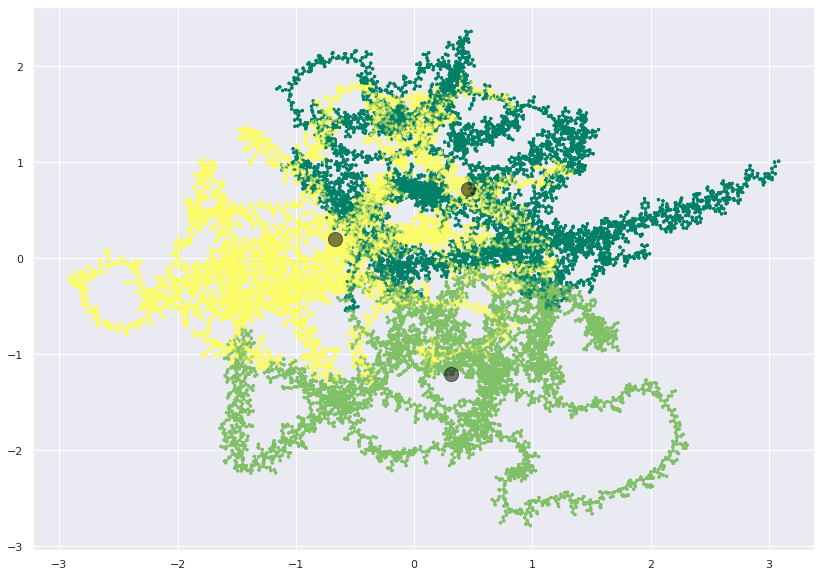

In [90]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.predict(X)

figure(figsize=(14,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## How to Write Parquet Files

In [177]:
table = pa.Table.from_pandas(pd.DataFrame(r[:5]))
pq.write_table(table, 'repr_random.parquet')

## Proof of Concept for Randomly Sampling Proteins, Unzipping & Processing

In [ ]:
data=[]
stats = [0, 0]
result = []
alias = 'tmp.cif.gz'

for file in random.sample(filenames, 10):
    blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
    blob.download_to_filename(alias)

    with gzip.open(alias) as f:
        file_content = f.read()

    txt = io.StringIO(file_content.decode("utf-8"))

    stats[0] += 1
    pRd = PdbxReader(txt)
    pRd.read(data)
    txt.close()
    block = data[0]

    obj = block.get_object("atom_site")

    for row in obj.get()[2]:
        result.append(row)

    stats[1] += len(obj.get()[2])

os.remove(alias)
print(f'Processed {stats[0]} proteins ({stats[1]} rows).')

In [ ]:
atoms = pd.DataFrame(data=result, columns=obj.item_name_list, dtype=float)
atoms.sample(10)

## Misc.

In [ ]:
# NOT USED CURRENTLY
# extract protein names from filenames and generate 500 len random vector for each

#r = []
#for f in filenames:
#    r.append([f[30:].split("-", 1)[0], [random.random() for n in range(500)]])
#r = np.array(r)
#X = np.stack(r[:,1], axis=0)